# Оцениваем разные спецификации для HS2

In [1]:
library(arrow)
library(stargazer)
library(tidyverse)
library(plotly)
library(fixest)


Присоединяю пакет: 'arrow'


Следующий объект скрыт от 'package:utils':

    timestamp



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"пакет 'tidyverse' был собран под R версии 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"пакет 'plotly' был собран под R версии 4.4.2"

Присоеди

In [2]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs2_x_covid.parquet.gzip')
# Добавить везде _i для симметрии
df$deaths_i = df$deaths
df$deaths_j = df$`deaths:r_j`

df$median_age_i = df$median_age
df$median_age_j = df$`median_age:r_j`

df$population_density_i = df$population_density
df$population_density_j = df$`population_density:r_j`

df$share_1_members_i = df$share_1_members
df$share_1_members_j = df$`share_1_members:r_j`

df$H6M_Facial_Coverings_i = df$H6M_Facial_Coverings
df$H6M_Facial_Coverings_j = df$`H6M_Facial_Coverings:r_j`

df$C8EV_International_travel_controls_i = df$C8EV_International_travel_controls
df$C8EV_International_travel_controls_j = df$`C8EV_International_travel_controls:r_j`
df %>% head()

t,i,j,category,v,q,v19,q19,country,t:r_i,⋯,median_age_i,median_age_j,population_density_i,population_density_j,share_1_members_i,share_1_members_j,H6M_Facial_Coverings_i,H6M_Facial_Coverings_j,C8EV_International_travel_controls_i,C8EV_International_travel_controls_j
<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021,SVK,RUS,12,37.881,18.000,310.385,104.000,SVK,2021,⋯,39.805,38.441,113.43900,8.881629,25.33,25.69,3.065753,2.3150685,1.545205,2.6109588
2021,JAM,FRA,04,7.270,4.502,0.160,0.022,JAM,2021,⋯,29.746,41.080,260.68984,123.059446,NA,NA,3.095891,3.2000000,2.427397,2.0520549
2021,AGO,CHN,74,13144.124,1492.615,1866.895,333.660,AGO,2021,⋯,16.302,37.026,25.96906,149.948180,10.81,14.53,2.895890,2.4054794,2.487671,2.5479453
2022,PAK,CHE,84,257.766,17.832,150.195,2.863,PAK,2022,⋯,19.652,41.582,299.39926,217.042782,1.08,NA,2.969863,0.4931507,1.000000,0.1287671
2021,CUB,CZE,24,1600.466,4.743,1647.356,4.901,CUB,2021,⋯,41.096,41.963,107.92723,138.226810,21.14,32.51,3.315068,2.6356165,1.838356,2.4712329
2020,GBR,LKA,05,209.375,0.083,174.662,0.100,GBR,2020,⋯,39.091,31.816,276.26308,352.431695,30.58,NA,1.579235,2.4699454,1.153005,2.3087432


In [3]:
# Pulled OLS
m0 = feols(log(v/v19) ~ log(deaths_i) + log(deaths_j) +
 C8EV_International_travel_controls_i + C8EV_International_travel_controls_j| year,
 data = df)
m0 %>% summary(cluster = ~ i^category+j^category)

NOTE: 201,840 observations removed because of NA and infinite values (RHS: 201,840).



OLS estimation, Dep. Var.: log(v/v19)
Observations: 1,688,768
Fixed-effects: year: 3
Standard-errors: Clustered (i^category & j^category) 
                                      Estimate Std. Error  t value   Pr(>|t|)
log(deaths_i)                        -0.004933   0.001299 -3.79819 1.4634e-04
log(deaths_j)                        -0.003739   0.001113 -3.36050 7.7998e-04
C8EV_International_travel_controls_i -0.027423   0.003357 -8.16952 3.3454e-16
C8EV_International_travel_controls_j -0.023852   0.002999 -7.95391 1.9374e-15
                                        
log(deaths_i)                        ***
log(deaths_j)                        ***
C8EV_International_travel_controls_i ***
C8EV_International_travel_controls_j ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.46761     Adj. R2: 0.004419
                Within R2: 2.309e-4

In [4]:
# FE (т.е. оценка на панельных данных с использованием внутригрупповой дисперсии)
m1 = feols(log(v/v19) ~ log(deaths_i) + log(deaths_j) +
 C8EV_International_travel_controls_i + C8EV_International_travel_controls_j| i + j + category +year,
 data = df)
m1 %>% summary(cluster = ~ i^category+j^category)

NOTE: 201,840 observations removed because of NA and infinite values (RHS: 201,840).



OLS estimation, Dep. Var.: log(v/v19)
Observations: 1,688,768
Fixed-effects: i: 175,  j: 175,  category: 96,  year: 3
Standard-errors: Clustered (i^category & j^category) 
                                      Estimate Std. Error  t value   Pr(>|t|)
log(deaths_i)                        -0.003270   0.001475 -2.21720 2.6624e-02
log(deaths_j)                        -0.011519   0.001313 -8.77570  < 2.2e-16
C8EV_International_travel_controls_i -0.013569   0.003142 -4.31827 1.5828e-05
C8EV_International_travel_controls_j -0.029011   0.002975 -9.75181  < 2.2e-16
                                        
log(deaths_i)                        *  
log(deaths_j)                        ***
C8EV_International_travel_controls_i ***
C8EV_International_travel_controls_j ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.45977     Adj. R2: 0.014776
                Within R2: 1.045e-4

In [ ]:
# По-другому включаю фиксированные эффекты категории
m2 = feols(log(v/v19) ~ log(deaths_i) + log(deaths_j) +
 C8EV_International_travel_controls_i + C8EV_International_travel_controls_j| i^category + j^category + year,
 data = df)
m2 %>% summary(cluster = ~ i^category+j^category)

NOTE: 201,840 observations removed because of NA and infinite values (RHS: 201,840).



OLS estimation, Dep. Var.: log(v/v19)
Observations: 1,688,768
Fixed-effects: i^category: 14,779,  j^category: 16,571,  year: 3
Standard-errors: Clustered (i^category & j^category) 
                                      Estimate Std. Error  t value   Pr(>|t|)
log(deaths_i)                        -0.003078   0.001466 -2.09939 3.5800e-02
log(deaths_j)                        -0.011592   0.001296 -8.94197  < 2.2e-16
C8EV_International_travel_controls_i -0.013433   0.003136 -4.28389 1.8482e-05
C8EV_International_travel_controls_j -0.029208   0.002956 -9.87953  < 2.2e-16
                                        
log(deaths_i)                        *  
log(deaths_j)                        ***
C8EV_International_travel_controls_i ***
C8EV_International_travel_controls_j ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.42017     Adj. R2: 0.05011 
                Within R2: 1.107e-4

In [ ]:
# Гетерогенность по категории не влезла в оперативку (22 Гб с годом, 6 Гб без года)
# m3 = feols(log(v/v19) ~ year:category/log(deaths_i) + year:category/log(deaths_j) +
# year:category/C8EV_International_travel_controls_i + year:category/C8EV_International_travel_controls_j| i^category + j^category,
#  data = df)
m3 = feols(log(v/v19) ~ category/log(deaths_i) + category/log(deaths_j) +
category/C8EV_International_travel_controls_i + category/C8EV_International_travel_controls_j| i^category + j^category,
 data = df) 
m3 %>% summary(cluster = ~ i^category+j^category)

ERROR: Error in feols(log(v/v19) ~ category/log(deaths_i) + category/log(deaths_j) + : Evaluation of the right-hand-side of the formula raises an error: 
  не могу разместить вектор размером 6.8 Gb


In [11]:
etable(m0, m1, m2, vcov = ~i^category+j^category+year)

,,m0,m1,m2
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,log(v/v19),log(v/v19),log(v/v19)
2,,,,
3,log(deaths_i),-0.0049 (0.0045),-0.0031 (0.0011),-0.0031 (0.0011)
4,log(deaths_j),-0.0037. (0.0010),-0.0116* (0.0025),-0.0116* (0.0025)
5,C8EV_International_travel_controls_i,-0.0274* (0.0030),-0.0134 (0.0068),-0.0134 (0.0068)
6,C8EV_International_travel_controls_j,-0.0238 (0.0215),-0.0292. (0.0099),-0.0292. (0.0099)
7,Fixed-Effects:,-----------------,-----------------,-----------------
8,year,Yes,Yes,Yes
9,i-category,No,Yes,Yes


In [12]:
etable(m0, m1, m2, vcov = ~i^category+j^category)

,,m0,m1,m2
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,log(v/v19),log(v/v19),log(v/v19)
2,,,,
3,log(deaths_i),-0.0049*** (0.0013),-0.0031* (0.0015),-0.0031* (0.0015)
4,log(deaths_j),-0.0037*** (0.0011),-0.0116*** (0.0013),-0.0116*** (0.0013)
5,C8EV_International_travel_controls_i,-0.0274*** (0.0034),-0.0134*** (0.0031),-0.0134*** (0.0031)
6,C8EV_International_travel_controls_j,-0.0238*** (0.0030),-0.0292*** (0.0030),-0.0292*** (0.0030)
7,Fixed-Effects:,-------------------,-------------------,-------------------
8,year,Yes,Yes,Yes
9,i-category,No,Yes,Yes


In [ ]:
# Добавить инструменты

## Фиксированные эффекты

### Экспорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [11]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs2_export_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,category,value,country:r,t,cases,deaths,tests,C8EV_International_travel_controls,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,ABW,03,5.267693,ABW,2020,133.9801,1.204475,NA,2.051913,⋯,NA,NA,NA,ABW,2.89,21.37,46.77,25.59,2020,0
2020,ABW,07,-1.537117,ABW,2020,133.9801,1.204475,NA,2.051913,⋯,NA,NA,NA,ABW,2.89,21.37,46.77,25.59,2020,0
2020,ABW,15,4.671670,ABW,2020,133.9801,1.204475,NA,2.051913,⋯,NA,NA,NA,ABW,2.89,21.37,46.77,25.59,2020,0
2020,ABW,16,-1.565421,ABW,2020,133.9801,1.204475,NA,2.051913,⋯,NA,NA,NA,ABW,2.89,21.37,46.77,25.59,2020,0
2020,ABW,17,-5.132723,ABW,2020,133.9801,1.204475,NA,2.051913,⋯,NA,NA,NA,ABW,2.89,21.37,46.77,25.59,2020,0
2020,ABW,18,-3.772261,ABW,2020,133.9801,1.204475,NA,2.051913,⋯,NA,NA,NA,ABW,2.89,21.37,46.77,25.59,2020,0


In [ ]:
# Результат сходится с (Berthou, 2024), если не делать кластеризацию ошибок. Иначе значимого эффекта нет. Заставляет задуматься.
feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country+category+year,
 data = df) %>% summary(vcov = ~country+year)
m1 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country^category +  year^category,
 data = df)
m1 %>% summary(vcov = ~country+year)

NOTE: 6,261 observations removed because of NA and infinite values (RHS: 6,261).



OLS estimation, Dep. Var.: value
Observations: 42,148
Fixed-effects: country: 175,  category: 96,  year: 3
Standard-errors: Clustered (country & year) 
                                    Estimate Std. Error   t value Pr(>|t|) 
log(deaths)                        -0.000593   0.005506 -0.107674  0.92408 
C8EV_International_travel_controls -0.021152   0.014301 -1.479073  0.27722 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.76793     Adj. R2: 0.51019 
                Within R2: 2.244e-5

NOTE: 6,261 observations removed because of NA and infinite values (RHS: 6,261).



OLS estimation, Dep. Var.: value
Observations: 42,148
Fixed-effects: country^category: 14,809,  year^category: 288
Standard-errors: Clustered (country & year) 
                                    Estimate Std. Error   t value Pr(>|t|) 
log(deaths)                         0.000620   0.006195  0.100124  0.92938 
C8EV_International_travel_controls -0.027324   0.013388 -2.041022  0.17803 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.521132     Adj. R2: 0.934117
                 Within R2: 4.426e-4

NOTE: 532 observations removed because of NA values (Breakup: X: 532, f: 0).



Warning message in log(deaths):
"созданы NaN"
Warning message:
"Removed 22080 rows containing missing values or values outside the scale range
(`geom_point()`)."


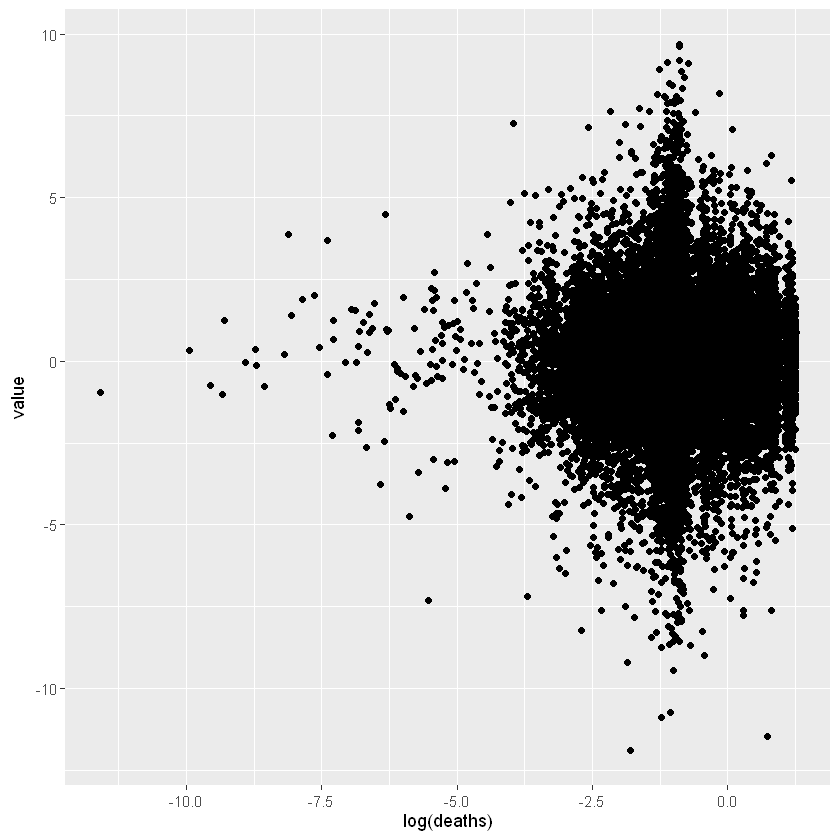

In [10]:
demean(df[, c('deaths', 'value')], df[, c('country', 'category', 'year')]) %>% ggplot(., aes(x = log(deaths), y = value)) + geom_point()